In [1]:
!pip install ultralytics datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import libraries
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from glob import glob
import random
import numpy as np
from IPython.display import display
from datasets import load_dataset, Dataset, DatasetDict
from PIL import Image
from sklearn.model_selection import train_test_split
import albumentations as A

from torch.utils.data import DataLoader

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Base path to dataset
base_path = "/content/drive/MyDrive/COMP4471/comp4471_project"

In [5]:
# Load dataset
ds = load_dataset("EduardoPacheco/FoodSeg103")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.71k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/351M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4983 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2135 [00:00<?, ? examples/s]

In [6]:
# Separate splits to train and validation set
train_dataset = ds["train"]
val_dataset = ds["validation"]


def split_test_dataset(train_dataset, val_dataset, num_samples):
    # Ensure num_samples does not exceed the lengths of the datasets
    if num_samples > len(train_dataset) or num_samples > len(val_dataset):
        raise ValueError(
            "num_samples cannot exceed the number of entries in either dataset."
        )

    # Randomly sample from the training dataset
    sampled_train_indices = random.sample(range(len(train_dataset)), num_samples)
    test_from_train = train_dataset.select(sampled_train_indices)

    # Remove sampled entries from the training dataset
    remaining_train_indices = list(
        set(range(len(train_dataset))) - set(sampled_train_indices)
    )
    updated_train_dataset = train_dataset.select(remaining_train_indices)

    # Randomly sample from the validation dataset
    sampled_val_indices = random.sample(range(len(val_dataset)), num_samples)
    test_from_val = val_dataset.select(sampled_val_indices)

    # Remove sampled entries from the validation dataset
    remaining_val_indices = list(
        set(range(len(val_dataset))) - set(sampled_val_indices)
    )
    updated_val_dataset = val_dataset.select(remaining_val_indices)

    # Combine test datasets
    test_dataset = Dataset.from_dict(
        {
            "image": test_from_train["image"] + test_from_val["image"],
            "label": test_from_train["label"] + test_from_val["label"],
            "classes_on_image": test_from_train["classes_on_image"]
            + test_from_val["classes_on_image"],
            "id": test_from_train["id"] + test_from_val["id"],
        }
    )

    return updated_train_dataset, updated_val_dataset, test_dataset


# Example usage
num_samples = 100  # Number of samples to extract from each dataset
train_dataset, val_dataset, test_dataset = split_test_dataset(
    train_dataset, val_dataset, num_samples
)

In [7]:
# Get dataset information
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 4983
    })
    validation: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 2135
    })
})


In [8]:
ingredients = np.array(
    [
        "background",
        "candy",
        "egg tart",
        "french fries",
        "chocolate",
        "biscuit",
        "popcorn",
        "pudding",
        "ice cream",
        "cheese butter",
        "cake",
        "wine",
        "milkshake",
        "coffee",
        "juice",
        "milk",
        "tea",
        "almond",
        "red beans",
        "cashew",
        "dried cranberries",
        "soy",
        "walnut",
        "peanut",
        "egg",
        "apple",
        "date",
        "apricot",
        "avocado",
        "banana",
        "strawberry",
        "cherry",
        "blueberry",
        "raspberry",
        "mango",
        "olives",
        "peach",
        "lemon",
        "pear",
        "fig",
        "pineapple",
        "grape",
        "kiwi",
        "melon",
        "orange",
        "watermelon",
        "steak",
        "pork",
        "chicken duck",
        "sausage",
        "fried meat",
        "lamb",
        "sauce",
        "crab",
        "fish",
        "shellfish",
        "shrimp",
        "soup",
        "bread",
        "corn",
        "hamburg",
        "pizza",
        "hanamaki baozi",
        "wonton dumplings",
        "pasta",
        "noodles",
        "rice",
        "pie",
        "tofu",
        "eggplant",
        "potato",
        "garlic",
        "cauliflower",
        "tomato",
        "kelp",
        "seaweed",
        "spring onion",
        "rape",
        "ginger",
        "okra",
        "lettuce",
        "pumpkin",
        "cucumber",
        "white radish",
        "carrot",
        "asparagus",
        "bamboo shoots",
        "broccoli",
        "celery stick",
        "cilantro mint",
        "snow peas",
        "cabbage",
        "bean sprouts",
        "onion",
        "pepper",
        "green beans",
        "French beans",
        "king oyster mushroom",
        "shiitake",
        "enoki mushroom",
        "oyster mushroom",
        "white button mushroom",
        "salad",
        "other ingredients",
    ]
)

Shape of training dataset: (4883, 4) 
Shape of validation dataset: (2035, 4)
Shape of test dataset: (200, 4)


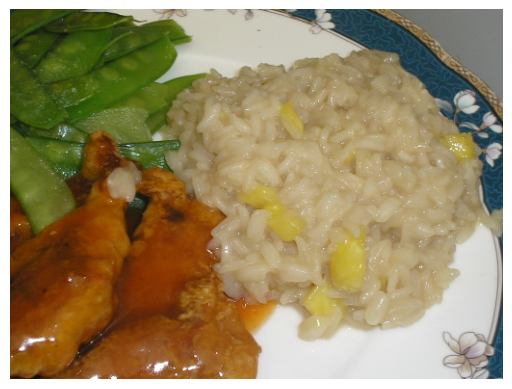

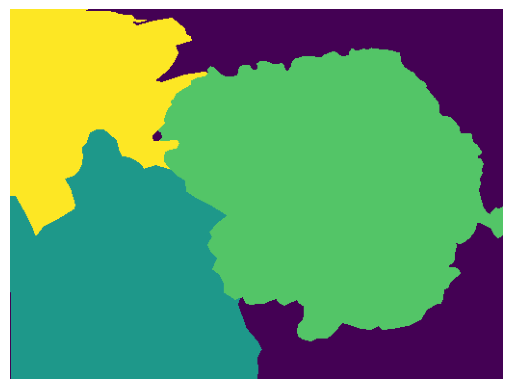

background
chicken duck
rice
snow peas


In [9]:
# Print sample items from dataset
print(
    f"Shape of training dataset: {train_dataset.shape} \nShape of validation dataset: {val_dataset.shape}\nShape of test dataset: {test_dataset.shape}"
)
# print(train_dataset[0]["id"])
# print(train_dataset[0]["image"])
# Display the image
image = train_dataset[0]["image"]
plt.imshow(image)
plt.axis("off")  # Turn off axis labels
plt.show()

# Display the label
label = train_dataset[0]["label"]
plt.imshow(label)
plt.axis("off")  # Turn off axis labels
plt.show()

# Print ingredient name according to the label
for index in train_dataset[0]["classes_on_image"]:
    if index < len(ingredients):
        print(ingredients[index])

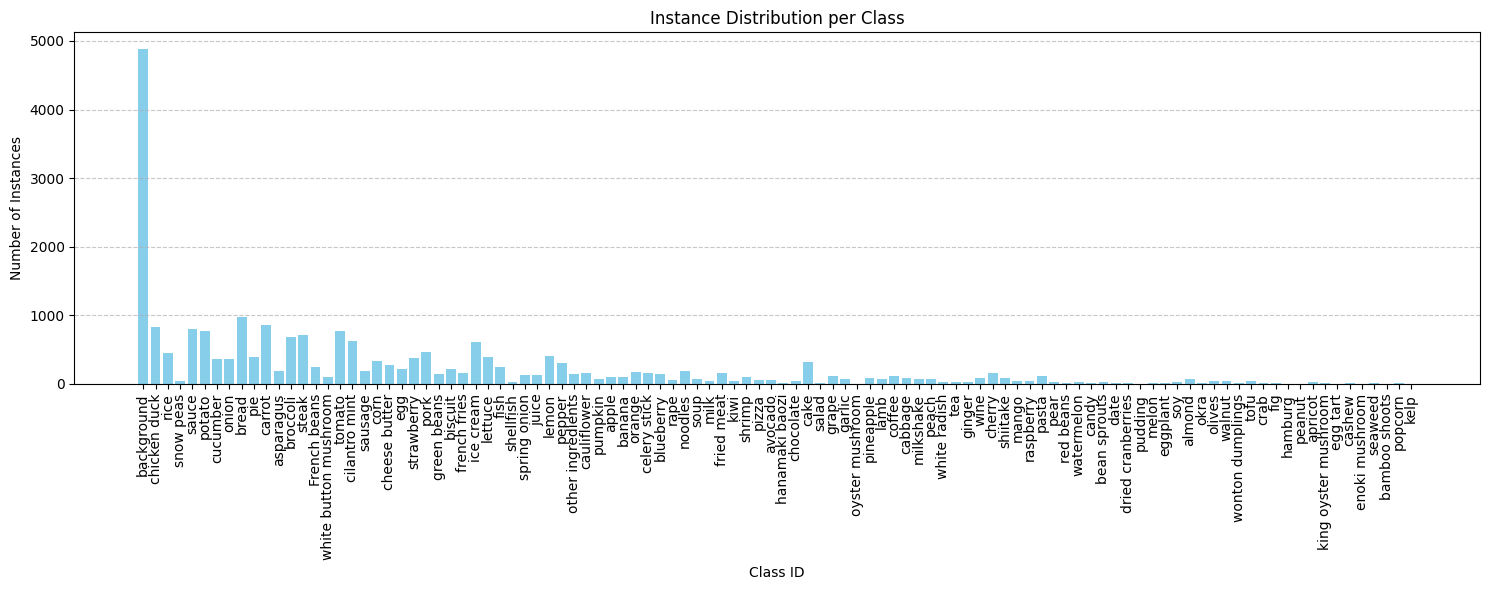

Class Distribution Summary:
           Class ID  Count
0        background   4882
1      chicken duck    836
2              rice    452
3         snow peas     46
4             sauce    802
..              ...    ...
99   enoki mushroom      6
100         seaweed      7
101   bamboo shoots      3
102         popcorn     10
103            kelp      1

[104 rows x 2 columns]


In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Check if the labels directory exists
if not ds:
    print("Database is not loaded!")
else:
    # Counter for class occurrences
    class_counter = Counter()

    # Iterate over each train item to add to counter
    for item in train_dataset:
        for class_id in item["classes_on_image"]:
            class_counter[ingredients[class_id]] += 1
    # Plotting the distribution
    classes, counts = zip(*(class_counter.items()))

    plt.figure(figsize=(15, 6))
    plt.bar(classes, counts, color="skyblue")
    plt.xlabel("Class ID")
    plt.ylabel("Number of Instances")
    plt.title("Instance Distribution per Class")
    plt.xticks(rotation=90)

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

class_summary = [
    {"Class ID": class_id, "Count": count} for class_id, count in class_counter.items()
]
class_summary_df = pd.DataFrame(class_summary)
print("Class Distribution Summary:")
print(class_summary_df)

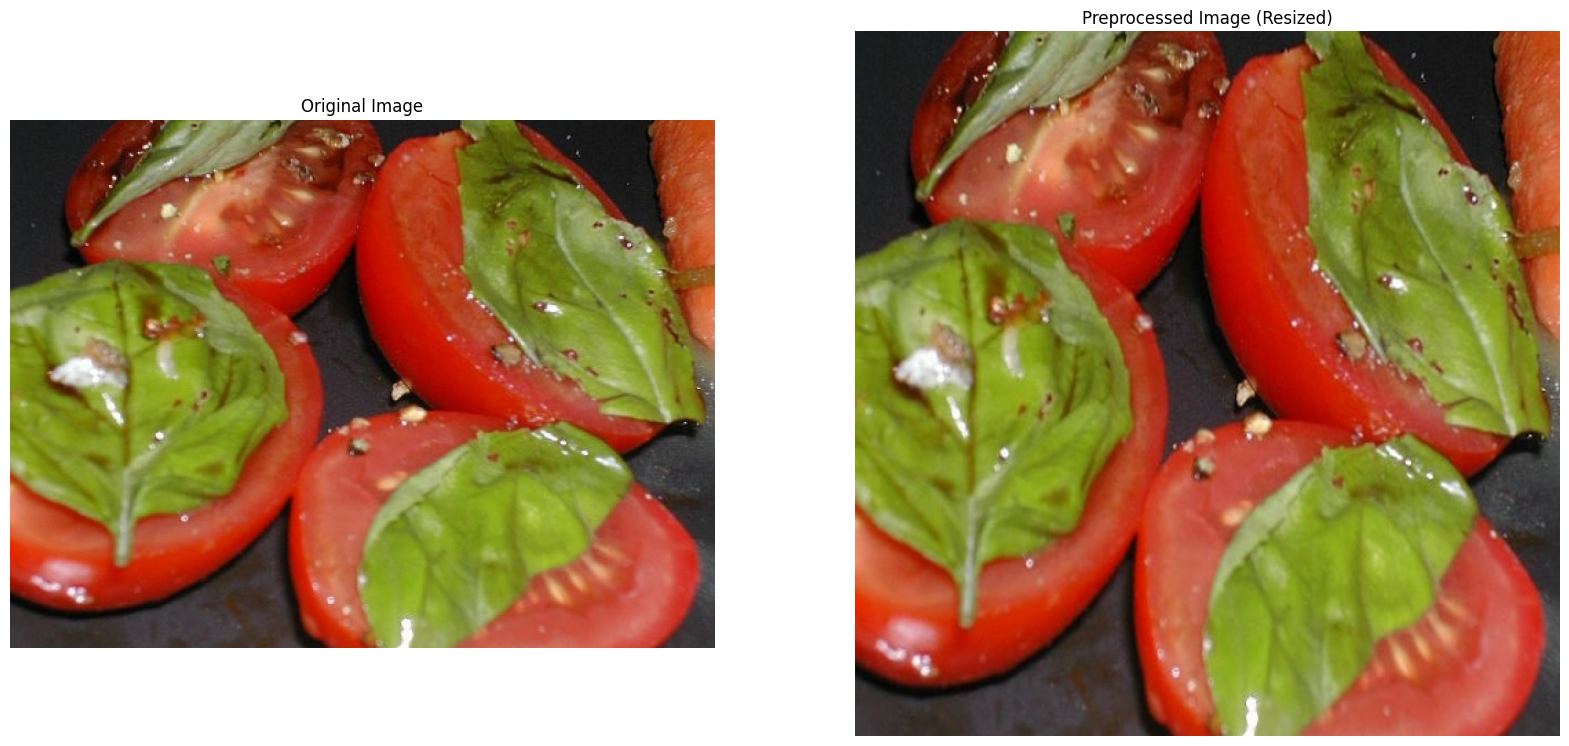

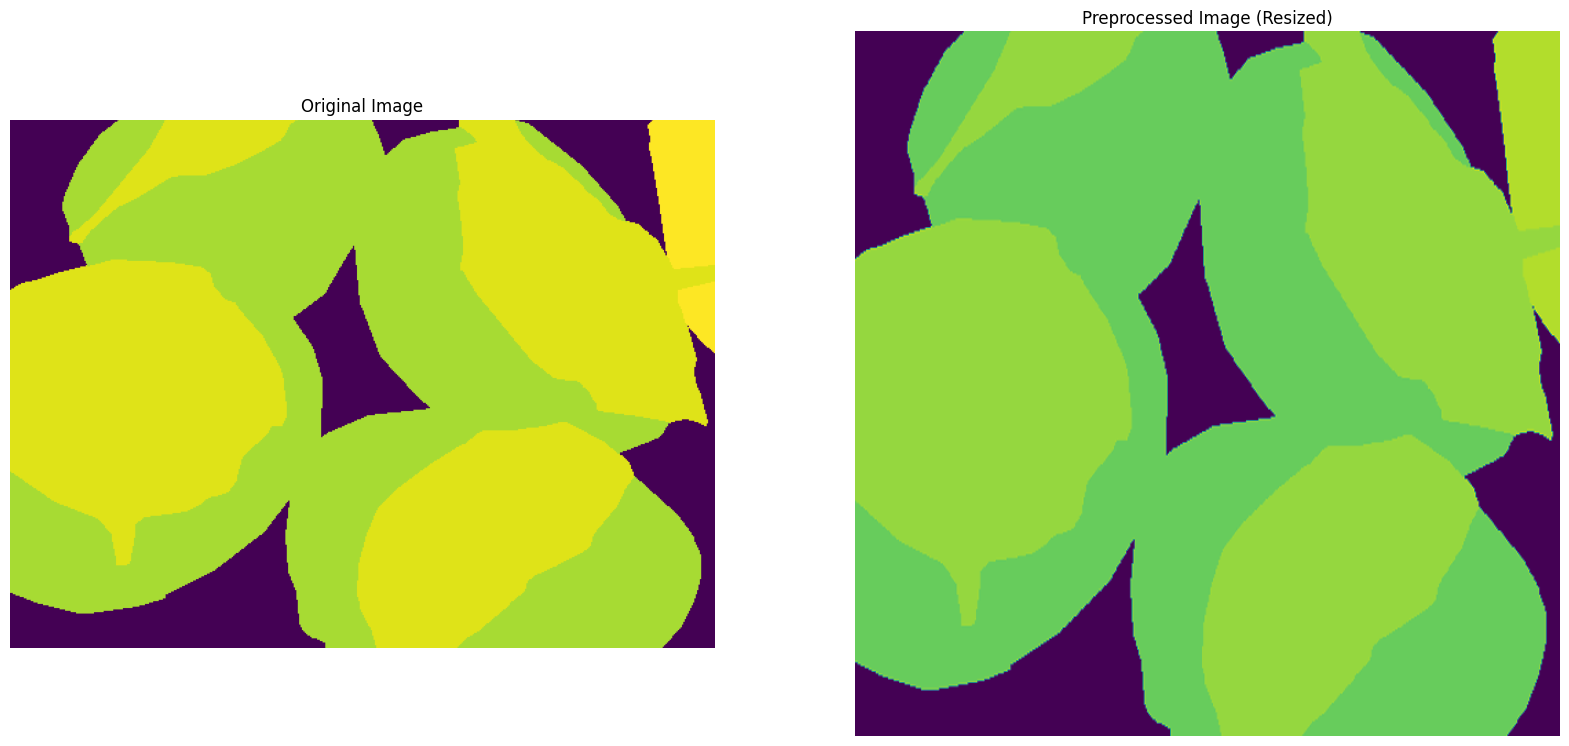

In [ ]:
def preprocess_image(original_image, size=(640, 640)):
    # Resize image
    preprocessed_image = original_image.resize(size)

    # Convert to NumPy array
    preprocessed_image = np.array(preprocessed_image)

    # Normalize image
    preprocessed_image = preprocessed_image / 255.0  # Scale to [0, 1]
    return original_image, preprocessed_image


def preprocess_mask(original_mask, size=(640, 640)):
    # Resize mask
    preprocessed_mask = original_mask.resize(size)  # Use nearest for masks

    # Convert to NumPy array
    preprocessed_mask = np.array(preprocessed_mask)

    # Normalize image
    preprocessed_mask = preprocessed_mask / 255.0  # Scale to [0, 1]

    return original_mask, preprocessed_mask


def plot_preprocessing_comparison(image, mask=False):
    if mask:
        original, preprocessed = preprocess_mask(image)
    else:
        original, preprocessed = preprocess_image(image)

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed)
    plt.title("Preprocessed Image (Resized)")
    plt.axis("off")

    plt.show()


# Visualize preprocessing on a random training image
sample = random.choice(train_dataset)
plot_preprocessing_comparison(sample["image"])
plot_preprocessing_comparison(sample["label"], mask=True)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


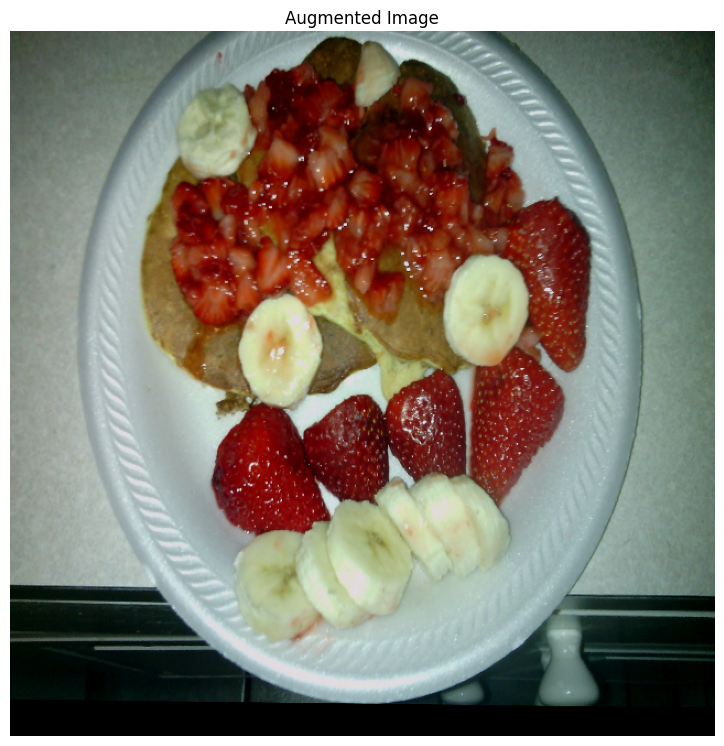

In [ ]:
# Add data augmentation
# Define data augmentation transformations
import albumentations as A


def random_data_augmentation(image, mask=None):
    # Define the augmentation pipeline
    augmentation = A.Compose(
        [
            A.HorizontalFlip(p=0.5),  # Flip images horizontally
            A.VerticalFlip(p=0.5),  # Flip images vertically
            A.RandomRotate90(p=0.5),  # Rotate images by 90 degrees
            A.RandomBrightnessContrast(
                brightness_limit=0.25,  # Limits for brightness adjustment
                contrast_limit=0.2,  # Limits for contrast adjustment
                p=0.5,  # Apply with a probability of 0.5
            ),
            A.ShiftScaleRotate(
                shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5
            ),
            A.Resize(height=640, width=640),  # Resize images
            A.Normalize(
                mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)
            ),  # Normalizing to [0, 1]
        ],
        p=1.0,
    )  # Apply all augmentations with a probability of 1.0

    # Apply the augmentations
    if mask is not None:
        augmented = augmentation(image=image, mask=mask)
        return augmented["image"], augmented["mask"]
    else:
        augmented = augmentation(image=image)
        return augmented["image"]


def show_random_data_augmentation(ds):
    # Sample random image and mask from your dataset
    sample = random.choice(ds)
    image = np.array(sample["image"])  # Convert PIL to NumPy array
    mask = np.array(sample["label"])  # Convert mask to NumPy array if available

    # Apply random data augmentation
    # augmented_image, augmented_mask = random_data_augmentation(image, mask)
    augmented_image = random_data_augmentation(image)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title("Augmented Image")
    plt.imshow(augmented_image)
    plt.axis("off")

    plt.show()


show_random_data_augmentation(train_dataset)

In [ ]:
# Perform data preprocessing on training dataset
def perform_preprocessing(dataset, augmentations=True):
    new_images = []
    new_labels = []

    for entry in dataset:
        original_image = entry["image"]
        original_label = entry["label"]

        # Preprocess the image and mask
        original_image, preprocessed_image = preprocess_image(original_image)
        original_label, preprocessed_mask = preprocess_mask(original_label)

        # Add original image and mask to the augmented lists
        new_images.append(preprocessed_image)
        new_labels.append(preprocessed_mask)

        # If augmentations are enabled, apply them
        # if augmentations:
        #     for _ in range(3):  # Generate 3 augmented versions of each image
        aug_image, aug_mask = random_data_augmentation(
            preprocessed_image, preprocessed_mask
        )
        new_images.append(aug_image)
        new_labels.append(aug_mask)

    # Convert lists to numpy arrays
    new_images = np.array(new_images)
    new_labels = np.array(new_labels)

    return new_images, new_labels


# train_dataset_preprocessed, train_dataset_preprocessed = perform_preprocessing(
#     train_dataset, augmentations=False
# )
# print(f"Shape of augmented images: {train_dataset_preprocessed.shape}")

# val_dataset_preprocessed, val_dataset_preprocessed = perform_preprocessing(
#     val_dataset, augmentations=False
# )
# print(f"Shape of augmented images: {val_dataset_preprocessed.shape}")

# test_dataset_preprocessed, test_dataset_preprocessed = perform_preprocessing(
#     test_dataset, augmentations=False
# )

# Training


In [ ]:
import numpy as np
import cv2
from PIL import Image
import os


def process_sample(image, mask, classes_on_image, img_id, output_dir):
    # Convert Pillow images to NumPy arrays
    img_np = np.array(image)
    mask_np = np.array(mask)
    height, width = mask_np.shape

    # Prepare output paths
    img_path = os.path.join(output_dir, "images", f"{img_id}.jpg")
    label_path = os.path.join(output_dir, "labels", f"{img_id}.txt")

    # Save image as JPEG
    Image.fromarray(img_np).save(img_path)

    # Generate annotations
    annotations = []
    for class_id in classes_on_image:
        # Create binary mask for this class
        binary_mask = (mask_np == class_id).astype(np.uint8)

        # Find connected components
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
            binary_mask, connectivity=8
        )

        # Process each component (skip label 0, background of binary mask)
        for label in range(1, num_labels):
            component_mask = (labels == label).astype(np.uint8)
            contours, _ = cv2.findContours(
                component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )

            if contours:
                contour = contours[0]  # Take the largest contour
                if len(contour) >= 3:  # Minimum points for a polygon
                    # Normalize coordinates
                    contour_flat = contour.reshape(-1, 2) / [width, height]
                    contour_str = " ".join(
                        [f"{x:.6f} {y:.6f}" for x, y in contour_flat]
                    )
                    annotations.append(
                        f"{class_id} {contour_str}"
                    )  # Adjust class_id to 0-based

    # Save annotations to text file
    os.makedirs(os.path.dirname(label_path), exist_ok=True)
    with open(label_path, "w") as f:
        f.write("\n".join(annotations))


# Example directory structure
data_dir = "foodseg103_yolo"
for split, ds in [("train", train_dataset), ("val", val_dataset)]:
    img_dir = os.path.join(base_path, data_dir, split, "images")
    label_dir = os.path.join(base_path, data_dir, split, "labels")
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    for sample in ds:
        process_sample(
            sample["image"],
            sample["label"],
            sample["classes_on_image"],
            sample["id"],
            os.path.join(base_path, data_dir, split),
        )

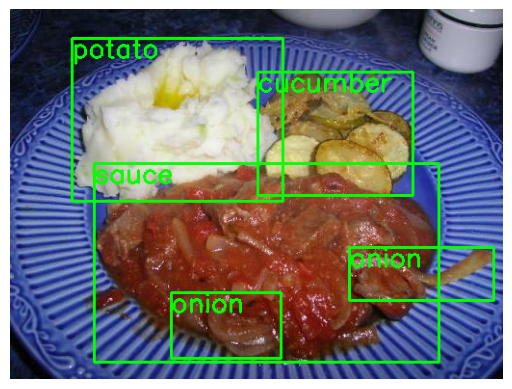

In [ ]:
import cv2
import numpy as np


def draw_bounding_boxes(image_path, label_path, class_names=None):
    """
    Draws bounding boxes on an image based on instance annotations from process_sample.

    Parameters:
    - image_path: str, path to the image file (e.g., 'path/to/image.jpg').
    - label_path: str, path to the annotation text file (e.g., 'path/to/labels.txt').
    - class_names: list of str, optional, names of classes for labeling (e.g., ['class1', 'class2']).

    Returns:
    - None: Displays the image with bounding boxes and optionally saves it.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at: {image_path}")
    height, width = image.shape[:2]

    # Read the annotation file
    try:
        with open(label_path, "r") as f:
            annotations = f.readlines()
    except FileNotFoundError:
        raise FileNotFoundError(f"Annotation file not found at: {label_path}")

    # Process each annotation
    for annotation in annotations:
        parts = annotation.strip().split()
        if len(parts) < 3:  # Must have at least class_id and one (x, y) pair
            continue

        # Extract class ID and contour points
        class_id = int(parts[0])
        if class_id != 0:
            contour = []
            for i in range(1, len(parts), 2):
                try:
                    x = float(parts[i]) * width  # Denormalize x coordinate
                    y = float(parts[i + 1]) * height  # Denormalize y coordinate
                    contour.append([x, y])
                except IndexError:
                    break  # Incomplete pair, stop processing this annotation
            if not contour:
                continue

            # Convert contour to numpy array and compute bounding box
            contour = np.array(contour, dtype=np.int32)
            x, y, w, h = cv2.boundingRect(contour)

            # Draw bounding box on the image
            color = (0, 255, 0)  # Green color in BGR
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)

            # Optionally, draw class label if class_names provided
            if (
                class_names is not None
                and len(class_names) > 0
                and class_id < len(class_names)
            ):
                label = class_names[class_id]
                cv2.putText(
                    image, label, (x, y + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2
                )

    # Display the image
    # Convert image from BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis("off")  # Turn off axis for a cleaner display
    plt.show()


# Example usage
image_path = os.path.join(base_path, "foodseg103_yolo/train/images/1.jpg")
label_path = os.path.join(base_path, "foodseg103_yolo/train/labels/1.txt")
draw_bounding_boxes(image_path, label_path, ingredients)

In [ ]:
def tune_hyperparameters(
    hyperparams_list,
    model_name="yolov8n.pt",
    epochs=10,
    imgsz=640,
):
    """
    Tunes hyperparameters for a YOLOv8 model and returns the model with the highest result.

    Args:
        hyperparams_list (list): List of dictionaries, each containing hyperparameter settings.
        train_dataset (str): Path to the training dataset (assumed to be referenced in data.yaml).
        val_dataset (str): Path to the validation dataset (assumed to be referenced in data.yaml).
        model_name (str): Name or path of the YOLO model to initialize (default: "yolov8n.pt").
        epochs (int): Number of training epochs (default: 10).
        imgsz (int): Image size for training (default: 640).

    Returns:
        YOLO: The trained model with the best performance based on validation mAP.
    """
    # Initialize variables to track the best performance
    # best_metric = -1  # Higher is better (e.g., mAP)
    # best_weights_path = None
    map_results = []  # To store (label, best_map) for each setting

    # Iterate over each hyperparameter configuration
    for i, hyperparams in enumerate(hyperparams_list):
        print(f"Training run {i} with hyperparameters: {hyperparams}")

        # Initialize a fresh YOLO model for each run
        model = YOLO(model_name)

        # Train the model with the current hyperparameters
        # Results are saved in a unique directory: hyperparam_tuning/run_{i}
        model.train(
            data= os.path.join(base_path, "data.yaml"),  # Assumes data.yaml is configured with train and val paths
            epochs=epochs,
            imgsz=imgsz,
            # project="hyperparam_tuning",
            name=f"run_{i}",
            verbose=False,
            **hyperparams,  # Unpack hyperparams dictionary into keyword arguments
        )

        # Load the results.csv file to extract the best validation metric
        # results_path = os.path.join(run.save_dir, "results.csv")
        # results_df = pd.read_csv(results_path)

        # Get the maximum mAP50-95 for bounding boxes (adjust metric as needed)
        # metric = results_df["metrics/mAP50-95(B)"].max()
        # print(f"Run {i} achieved mAP50-95(B): {metric}")
        metrics = model.val(data=os.path.join(base_path, "data.yaml"))

        # Exract mAP and f1 metrics
        map50 = metrics.box.map50
        map50_95 = metrics.box.map
        f1 = metrics.box.f1
        print(f"mAP@0.5:0.95: {map50_95}, F1: {f1}")

        map_results.append(
            {
                "hyperparameters": hyperparams,
                "mAP@0.5": map50,
                "mAP@0.5:0.95": map50_95,
                "F1": f1,
            }
        )

        print(
            f"Completed training run {i}: \nmAP@0.5: map50 \nmAP@0.5:0.95: {map50_95} \nF1: {f1}"
        )

        # map_results.append((f"Option {i + 1}", metric))

        # Update best metric and weights path if current metric is higher
        # if metric > best_metric:
        #     best_metric = metric
        #     best_weights_path = os.path.join(run.save_dir, "weights", "best.pt")
        #     print(f"New best metric: {metric} (run {i})")

    # Plot the bar graph for best mAP of each setting
    # labels = [label for label, _ in map_results]
    # maps = [map_value for _, map_value in map_results]

    # plt.figure(figsize=(10, 6))
    # plt.bar(labels, maps)
    # plt.xlabel("Hyperparameter Settings")
    # plt.ylabel("Best mAP50-95(B)")
    # plt.title("Best mAP for Each Hyperparameter Setting")
    # plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    # for i, v in enumerate(maps):
    #     plt.text(i, v + 0.01, f"{v:.3f}", ha="center")  # Add mAP values on top of bars
    # plt.show()

    # Load the model with the best weights
    # if best_weights_path:
    #     best_model = YOLO(best_weights_path)
    #     print(
    #         f"Best model loaded from {best_weights_path} with mAP50-95(B): {best_metric} \n with hyperparameters: {hyperparams_list[np.argmax(maps)]}"
    #     )
    # else:
    #     raise ValueError("No successful training runs completed.")

    return map_results

In [ ]:
# Define hyperparameter configurations
hyperparameter_configs = [
    {
        "lr0": 0.01,
        "lrf": 0.01,
        "momentum": 0.937,
        "weight_decay": 0.0005,
        "warmup_epochs": 3.0,
        "warmup_momentum": 0.8,
        "warmup_bias_lr": 0.1,
        "box": 0.05,  # Box loss gain
        "cls": 0.5,  # Class loss gain
        "dfl": 1.0,  # Distribution focal loss gain
    },
    {
        "lr0": 0.005,
        "lrf": 0.02,
        "momentum": 0.9,
        "weight_decay": 0.0003,
        "warmup_epochs": 2.0,
        "warmup_momentum": 0.85,
        "warmup_bias_lr": 0.05,
        "box": 0.04,
        "cls": 0.6,
        "dfl": 1.2,
    }, # Best one
    {
        "lr0": 0.001,
        "lrf": 0.02,
        "momentum": 0.95,
        "weight_decay": 0.0004,
        "warmup_epochs": 4.0,
        "warmup_momentum": 0.75,
        "warmup_bias_lr": 0.15,
        "box": 0.06,
        "cls": 0.4,
        "dfl": 0.9,
    },
    # Add more hyperparameter configurations if needed
]

# Run hyperparameter tuning and training
results = tune_hyperparameters(
    hyperparams_list=hyperparameter_configs,
    # train_dataset="./foodseg103_yolo/train",  # Replace with actual path
    # val_dataset="./foodseg103_yolo/val",  # Replace with actual path
    model_name="yolov8n.pt",
    epochs=10,
    imgsz=640,
)

Training run 0 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.5, 'dfl': 1.0}
Ultralytics 8.3.95 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/COMP4471/comp4471_project/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=run_06, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=

100%|██████████| 5.35M/5.35M [00:00<00:00, 300MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/COMP4471/comp4471_project/foodseg103_yolo/train/labels... 4883 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4883/4883 [01:52<00:00, 43.25it/s]


train: New cache created: /content/drive/MyDrive/COMP4471/comp4471_project/foodseg103_yolo/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/COMP4471/comp4471_project/foodseg103_yolo/val/labels... 2035 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2035/2035 [00:43<00:00, 46.41it/s]


val: New cache created: /content/drive/MyDrive/COMP4471/comp4471_project/foodseg103_yolo/val/labels.cache
Plotting labels to runs/detect/run_06/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=9.3e-05, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/run_06
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.57G   0.007757      4.656     0.9746         27        640: 100%|██████████| 306/306 [02:31<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:32<00:00,  1.98it/s]


                   all       2035      18821      0.585     0.0236      0.016     0.0116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      6.25G   0.007357      3.706     0.9561         21        640: 100%|██████████| 306/306 [02:21<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:31<00:00,  2.06it/s]


                   all       2035      18821      0.625     0.0559      0.039      0.029

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      6.26G   0.007347      3.254     0.9487         27        640: 100%|██████████| 306/306 [02:25<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:30<00:00,  2.08it/s]


                   all       2035      18821       0.62     0.0818     0.0615     0.0454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      6.28G   0.007242      2.976     0.9384         27        640: 100%|██████████| 306/306 [02:23<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:31<00:00,  2.05it/s]


                   all       2035      18821      0.502      0.115     0.0836      0.062

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      6.29G   0.007096      2.787     0.9248         25        640: 100%|██████████| 306/306 [02:27<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:32<00:00,  1.96it/s]


                   all       2035      18821      0.539      0.138     0.0983     0.0739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      6.32G   0.006947      2.675     0.9124         36        640: 100%|██████████| 306/306 [02:25<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:32<00:00,  1.99it/s]


                   all       2035      18821      0.558      0.142       0.11     0.0825

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      6.33G   0.006833      2.584     0.9016         25        640: 100%|██████████| 306/306 [02:28<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:33<00:00,  1.90it/s]


                   all       2035      18821      0.549      0.149       0.12     0.0896

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      6.36G   0.006749       2.51     0.8956         40        640: 100%|██████████| 306/306 [02:33<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.85it/s]


                   all       2035      18821      0.527      0.151      0.124     0.0935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      6.37G   0.006645      2.464     0.8886         21        640: 100%|██████████| 306/306 [02:35<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:31<00:00,  2.01it/s]


                   all       2035      18821      0.515      0.162      0.129     0.0973

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       6.4G   0.006597      2.437     0.8843         17        640: 100%|██████████| 306/306 [02:36<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:33<00:00,  1.89it/s]


                   all       2035      18821       0.51      0.164       0.13     0.0988

10 epochs completed in 0.511 hours.
Optimizer stripped from runs/detect/run_06/weights/last.pt, 6.9MB
Optimizer stripped from runs/detect/run_06/weights/best.pt, 6.9MB

Validating runs/detect/run_06/weights/best.pt...
Ultralytics 8.3.95 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,341,936 parameters, 0 gradients, 9.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.79it/s]


                   all       2035      18821       0.51      0.164       0.13     0.0989
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/run_06
Ultralytics 8.3.95 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,341,936 parameters, 0 gradients, 9.6 GFLOPs


val: Scanning /content/drive/MyDrive/COMP4471/comp4471_project/foodseg103_yolo/val/labels.cache... 2035 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2035/2035 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:55<00:00,  2.30it/s]


                   all       2035      18821       0.52      0.163       0.13     0.0987
Speed: 0.3ms preprocess, 5.1ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/run_062
mAP@0.5:0.95: 0.09871714146601394, F1: [     0.5303           0           0     0.31143    0.056582     0.20417           0     0.36267           0     0.31072      0.1848      0.2865       0.517     0.31165    0.043624     0.17927    0.025652           0           0           0           0     0.02489           0           0    0.089527           0
           0           0     0.27995     0.45961     0.25909     0.47112     0.17441           0           0           0      0.4557           0           0           0      0.1331           0           0     0.25628           0     0.38425     0.19375     0.37205    0.060173           0           0     0.35751
           0     0.11651           0           0    0.054106     0.40362     0.68302           0           0           0       

train: Scanning /content/drive/MyDrive/COMP4471/comp4471_project/foodseg103_yolo/train/labels.cache... 4883 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4883/4883 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/COMP4471/comp4471_project/foodseg103_yolo/val/labels.cache... 2035 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2035/2035 [00:00<?, ?it/s]


Plotting labels to runs/detect/run_1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.9' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=9.3e-05, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/run_1
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.55G   0.006141      5.476      1.163         27        640: 100%|██████████| 306/306 [02:38<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:29<00:00,  2.18it/s]


                   all       2035      18821      0.661     0.0249     0.0204     0.0148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      6.17G   0.005913      4.281      1.149         21        640: 100%|██████████| 306/306 [02:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:31<00:00,  2.01it/s]


                   all       2035      18821      0.597     0.0736     0.0466     0.0346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      6.17G   0.005854      3.757      1.134         27        640: 100%|██████████| 306/306 [02:16<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]


                   all       2035      18821      0.579     0.0986     0.0715      0.053

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      6.17G   0.005738      3.462      1.118         27        640: 100%|██████████| 306/306 [02:17<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:30<00:00,  2.06it/s]


                   all       2035      18821      0.552      0.121     0.0904     0.0671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      6.17G   0.005624      3.266      1.103         25        640: 100%|██████████| 306/306 [02:22<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:30<00:00,  2.10it/s]


                   all       2035      18821      0.555       0.14      0.104     0.0787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      6.17G   0.005506      3.146      1.089         36        640: 100%|██████████| 306/306 [02:30<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:32<00:00,  2.00it/s]


                   all       2035      18821       0.55      0.145      0.115     0.0867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      6.17G   0.005429      3.048      1.077         25        640: 100%|██████████| 306/306 [02:23<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:36<00:00,  1.77it/s]


                   all       2035      18821      0.539      0.152      0.124     0.0934

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      6.17G   0.005356      2.966      1.069         40        640: 100%|██████████| 306/306 [02:37<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.87it/s]


                   all       2035      18821      0.535      0.151       0.13     0.0982

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      6.17G    0.00528      2.913      1.061         21        640: 100%|██████████| 306/306 [02:27<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:29<00:00,  2.17it/s]


                   all       2035      18821      0.526      0.161      0.133      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      6.17G   0.005238      2.883      1.055         17        640: 100%|██████████| 306/306 [02:33<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:30<00:00,  2.07it/s]


                   all       2035      18821       0.53       0.16      0.136      0.103

10 epochs completed in 0.505 hours.
Optimizer stripped from runs/detect/run_1/weights/last.pt, 6.9MB
Optimizer stripped from runs/detect/run_1/weights/best.pt, 6.9MB

Validating runs/detect/run_1/weights/best.pt...
Ultralytics 8.3.95 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,341,936 parameters, 0 gradients, 9.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]


                   all       2035      18821       0.53       0.16      0.136      0.103
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/run_1
Ultralytics 8.3.95 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,341,936 parameters, 0 gradients, 9.6 GFLOPs


val: Scanning /content/drive/MyDrive/COMP4471/comp4471_project/foodseg103_yolo/val/labels.cache... 2035 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2035/2035 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:53<00:00,  2.37it/s]


                   all       2035      18821       0.53      0.161      0.136      0.103
Speed: 0.5ms preprocess, 4.2ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/run_12
mAP@0.5:0.95: 0.10306481528206611, F1: [    0.53919           0           0     0.31706      0.1048     0.20479           0     0.37967           0     0.30283     0.21866       0.322     0.53632     0.33349    0.075355           0    0.024938           0           0           0           0    0.040741           0           0    0.097205           0
           0           0     0.30462     0.48142     0.25924     0.49996     0.18578           0           0           0      0.4813           0           0   0.0040291     0.11329           0           0     0.29202           0     0.37808     0.19665     0.37924    0.058943           0           0     0.37051
           0     0.11392           0           0    0.059187      0.4175     0.68837           0           0           0        

train: Scanning /content/drive/MyDrive/COMP4471/comp4471_project/foodseg103_yolo/train/labels.cache... 4883 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4883/4883 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/COMP4471/comp4471_project/foodseg103_yolo/val/labels.cache... 2035 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2035/2035 [00:00<?, ?it/s]


Plotting labels to runs/detect/run_2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.95' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=9.3e-05, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/run_2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       2.4G   0.009367      3.774      0.879         27        640: 100%|██████████| 306/306 [02:52<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:29<00:00,  2.20it/s]


                   all       2035      18821    0.00695       0.15     0.0134    0.00973

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      6.03G   0.008766       3.05      0.856         21        640: 100%|██████████| 306/306 [02:18<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]


                   all       2035      18821      0.616     0.0506     0.0333     0.0248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      6.05G   0.008766      2.682     0.8512         27        640: 100%|██████████| 306/306 [02:21<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]


                   all       2035      18821      0.611     0.0784      0.055     0.0408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      6.06G   0.008692      2.451     0.8445         27        640: 100%|██████████| 306/306 [02:18<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:30<00:00,  2.09it/s]


                   all       2035      18821      0.533      0.107     0.0768     0.0572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      6.07G   0.008546      2.284     0.8333         25        640: 100%|██████████| 306/306 [02:31<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:30<00:00,  2.10it/s]


                   all       2035      18821      0.546      0.129     0.0925     0.0697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      6.07G   0.008358       2.18     0.8222         36        640: 100%|██████████| 306/306 [02:37<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.83it/s]


                   all       2035      18821      0.549      0.135      0.106     0.0792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      6.07G   0.008208      2.101     0.8119         25        640: 100%|██████████| 306/306 [02:36<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:30<00:00,  2.13it/s]


                   all       2035      18821      0.543      0.145      0.115     0.0864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      6.07G   0.008101      2.036      0.806         40        640: 100%|██████████| 306/306 [02:32<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:30<00:00,  2.10it/s]


                   all       2035      18821      0.533      0.144       0.12     0.0911

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      6.07G   0.007967      1.995     0.7989         21        640: 100%|██████████| 306/306 [02:25<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:33<00:00,  1.93it/s]


                   all       2035      18821      0.518      0.157      0.125     0.0948

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      6.07G   0.007917      1.973     0.7952         17        640: 100%|██████████| 306/306 [02:40<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:31<00:00,  2.01it/s]


                   all       2035      18821      0.531      0.162      0.127     0.0969

10 epochs completed in 0.518 hours.
Optimizer stripped from runs/detect/run_2/weights/last.pt, 6.9MB
Optimizer stripped from runs/detect/run_2/weights/best.pt, 6.9MB

Validating runs/detect/run_2/weights/best.pt...
Ultralytics 8.3.95 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,341,936 parameters, 0 gradients, 9.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:36<00:00,  1.75it/s]


                   all       2035      18821      0.521      0.162      0.128      0.097
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/run_2
Ultralytics 8.3.95 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,341,936 parameters, 0 gradients, 9.6 GFLOPs


val: Scanning /content/drive/MyDrive/COMP4471/comp4471_project/foodseg103_yolo/val/labels.cache... 2035 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2035/2035 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:53<00:00,  2.38it/s]


                   all       2035      18821      0.531      0.161      0.128     0.0971
Speed: 0.5ms preprocess, 4.2ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/run_22
mAP@0.5:0.95: 0.0970597982390968, F1: [     0.5261           0           0     0.30245    0.044049     0.18081           0     0.35456           0     0.29268     0.17456      0.3141     0.49371     0.32425     0.04866    0.097124    0.025429           0           0           0           0    0.024946           0           0    0.094797           0
           0           0     0.29752      0.4524     0.25478     0.46862     0.15809           0           0           0     0.46486           0           0           0     0.15883           0           0     0.25514           0     0.37283     0.19585     0.37313     0.04059           0           0     0.34849
           0     0.10567           0           0    0.055176     0.41012     0.67763           0           0           0         

Hyperparameter set 1:
  lr0: 0.01
  lrf: 0.01
  momentum: 0.937
  weight_decay: 0.0005
  warmup_epochs: 3.0
  warmup_momentum: 0.8
  warmup_bias_lr: 0.1
  box: 0.05
  cls: 0.5
  dfl: 1.0
  mAP@0.5: 0.1301
  mAP@0.5:0.95: 0.0987

Hyperparameter set 2:
  lr0: 0.005
  lrf: 0.02
  momentum: 0.9
  weight_decay: 0.0003
  warmup_epochs: 2.0
  warmup_momentum: 0.85
  warmup_bias_lr: 0.05
  box: 0.04
  cls: 0.6
  dfl: 1.2
  mAP@0.5: 0.1357
  mAP@0.5:0.95: 0.1031

Hyperparameter set 3:
  lr0: 0.001
  lrf: 0.02
  momentum: 0.95
  weight_decay: 0.0004
  warmup_epochs: 4.0
  warmup_momentum: 0.75
  warmup_bias_lr: 0.15
  box: 0.06
  cls: 0.4
  dfl: 0.9
  mAP@0.5: 0.1276
  mAP@0.5:0.95: 0.0971



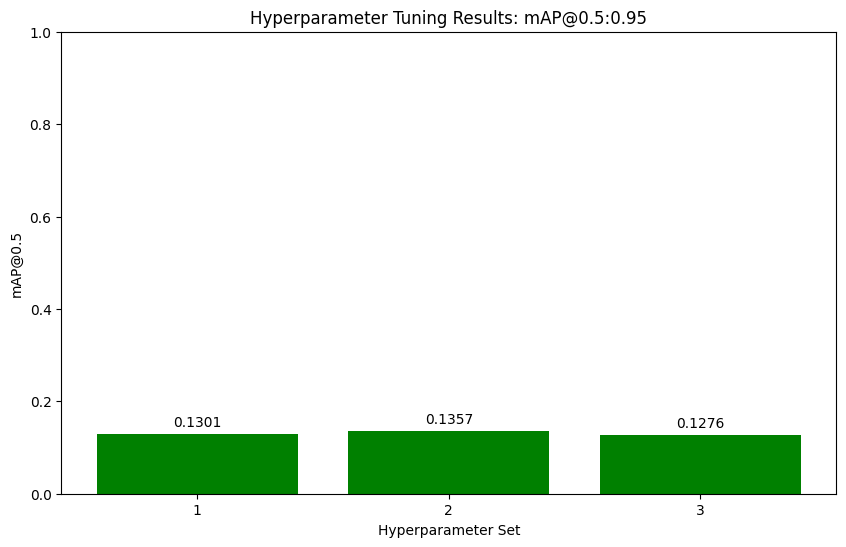

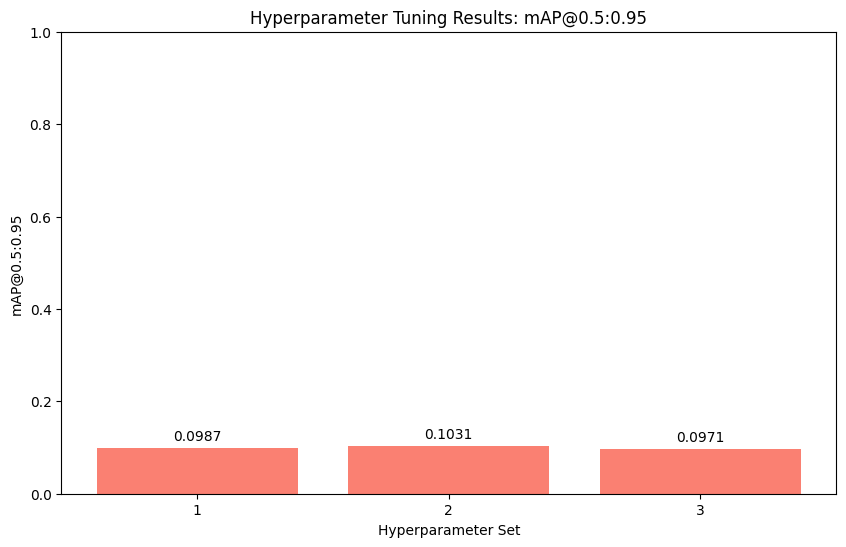

In [ ]:
def plot_results(metric_name, tuning_df, color):
    # Plot mAP@0.5:0.95 for each hyperparameter set
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(tuning_df) + 1), tuning_df[metric_name], color=color)
    plt.xlabel("Hyperparameter Set")
    plt.ylabel(metric_name)
    plt.title("Hyperparameter Tuning Results: mAP@0.5:0.95")
    plt.xticks(range(1, len(tuning_df) + 1))
    plt.ylim(0, 1)
    for i, v in enumerate(tuning_df[metric_name]):
        plt.text(i + 1, v + 0.01, f"{v:.4f}", ha="center", va="bottom")
    plt.show()

# print(results)
# Display the tuning results
for idx, res in enumerate(results):
    hyp = res["hyperparameters"]
    print(f"Hyperparameter set {idx + 1}:")
    for key, value in hyp.items():
        print(f"  {key}: {value}")
    print(f"  mAP@0.5: {res['mAP@0.5']:.4f}")
    print(f"  mAP@0.5:0.95: {res['mAP@0.5:0.95']:.4f}\n")
    # print(f"  F1: {res['F1']}\n")


# Create a DataFrame for plotting
tuning_df = pd.DataFrame(results)
plot_results("mAP@0.5", tuning_df, "green")
plot_results("mAP@0.5:0.95", tuning_df, "salmon")
# plot_results("F1", tuning_df, "skyblue")

In [ ]:
# Find the configuration with the highest mAP@0.5
best_result = max(results, key=lambda x: x["mAP@0.5:0.95"])

print("Best hyperparameters based on mAP@0.5:0.95:")
for key, value in best_result["hyperparameters"].items():
    print(f"  {key}: {value}")

print(f"mAP@0.5: {best_result['mAP@0.5']:.4f}")
print(f"mAP@0.5:0.95: {best_result['mAP@0.5:0.95']:.4f}")
# print(f"F1: {best_result['F1']:.4f}")

Best hyperparameters based on mAP@0.5:0.95:
  lr0: 0.005
  lrf: 0.02
  momentum: 0.9
  weight_decay: 0.0003
  warmup_epochs: 2.0
  warmup_momentum: 0.85
  warmup_bias_lr: 0.05
  box: 0.04
  cls: 0.6
  dfl: 1.2
mAP@0.5: 0.1357
mAP@0.5:0.95: 0.1031


In [12]:
# Best hyperparameters
# best_hyperparameters = best_result["hyperparameters"]
best_hyperparameters = {
        "lr0": 0.005,
        "lrf": 0.02,
        "momentum": 0.9,
        "weight_decay": 0.0003,
        "warmup_epochs": 2.0,
        "warmup_momentum": 0.85,
        "warmup_bias_lr": 0.05,
        "box": 0.04,
        "cls": 0.6,
        "dfl": 1.2,
    } # Best one

# Initialize the model
final_model = YOLO("yolov8n.pt")

# Retrain the model with the best hyperparameters
training_results = final_model.train(
    data=os.path.join(base_path, "data.yaml"), epochs=50, imgsz=640, verbose=False, **best_hyperparameters
)

Ultralytics 8.3.95 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/COMP4471/comp4471_project/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

100%|██████████| 755k/755k [00:00<00:00, 3.27MB/s]


Overriding model.yaml nc=80 with nc=104

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralyti

100%|██████████| 5.35M/5.35M [00:00<00:00, 15.6MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/COMP4471/comp4471_project/foodseg103_yolo/train/labels.cache... 4883 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4883/4883 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/COMP4471/comp4471_project/foodseg103_yolo/val/labels.cache... 2035 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2035/2035 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.9' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=9.3e-05, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.86G     0.0057      5.446      1.083         69        640: 100%|██████████| 306/306 [08:48<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:16<00:00,  3.81it/s]


                   all       2035      18821      0.629     0.0221     0.0146     0.0103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.48G   0.005701      4.229      1.093         46        640: 100%|██████████| 306/306 [01:29<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.27it/s]


                   all       2035      18821      0.565     0.0606     0.0392     0.0284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.48G   0.005705      3.555      1.104         82        640: 100%|██████████| 306/306 [01:30<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


                   all       2035      18821      0.502     0.0893      0.063     0.0456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.49G   0.005564      3.186      1.094         56        640: 100%|██████████| 306/306 [01:28<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.11it/s]


                   all       2035      18821       0.51      0.118     0.0819     0.0585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.49G   0.005358       2.92      1.078         67        640: 100%|██████████| 306/306 [01:26<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.04it/s]


                   all       2035      18821      0.536      0.131     0.0963     0.0697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.49G   0.005181      2.743       1.06         41        640: 100%|██████████| 306/306 [01:28<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.23it/s]


                   all       2035      18821      0.544      0.143      0.112     0.0815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.51G    0.00514      2.651      1.053         87        640: 100%|██████████| 306/306 [01:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.02it/s]


                   all       2035      18821      0.541      0.159      0.127     0.0939

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.51G   0.005061      2.572      1.039         36        640: 100%|██████████| 306/306 [01:29<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.19it/s]


                   all       2035      18821      0.546      0.156      0.131      0.097

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.51G    0.00496      2.496      1.028         58        640: 100%|██████████| 306/306 [01:27<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.13it/s]


                   all       2035      18821      0.554       0.17      0.143      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.51G   0.004924      2.464      1.021         91        640: 100%|██████████| 306/306 [01:30<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.14it/s]


                   all       2035      18821      0.508      0.186      0.147      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.51G   0.004895      2.413      1.018         41        640: 100%|██████████| 306/306 [01:26<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.09it/s]


                   all       2035      18821       0.54      0.185      0.155      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.51G   0.004819      2.361      1.008         51        640: 100%|██████████| 306/306 [01:27<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.22it/s]


                   all       2035      18821      0.557      0.182       0.16       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.51G   0.004813      2.332      1.007         81        640: 100%|██████████| 306/306 [01:26<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.12it/s]


                   all       2035      18821      0.553      0.199      0.166      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.51G   0.004784      2.303      1.004         69        640: 100%|██████████| 306/306 [01:28<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.20it/s]


                   all       2035      18821      0.483      0.197      0.172      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.51G   0.004743      2.271     0.9975         50        640: 100%|██████████| 306/306 [01:26<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.07it/s]


                   all       2035      18821      0.518      0.204      0.176      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.51G    0.00474      2.249     0.9959         60        640: 100%|██████████| 306/306 [01:27<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.16it/s]


                   all       2035      18821      0.499      0.212      0.181      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.53G   0.004698      2.211     0.9904         32        640: 100%|██████████| 306/306 [01:28<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.16it/s]


                   all       2035      18821      0.491      0.217      0.189      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.53G   0.004701      2.198     0.9898         51        640: 100%|██████████| 306/306 [01:27<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.08it/s]


                   all       2035      18821       0.52      0.203       0.19      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.53G   0.004687      2.184     0.9888         67        640: 100%|██████████| 306/306 [01:27<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.13it/s]


                   all       2035      18821      0.519      0.218      0.195       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.53G    0.00463      2.158     0.9813         45        640: 100%|██████████| 306/306 [01:29<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.09it/s]


                   all       2035      18821      0.503      0.211      0.199      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.53G   0.004639       2.13     0.9803         58        640: 100%|██████████| 306/306 [01:26<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.12it/s]


                   all       2035      18821       0.45      0.232      0.199      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.53G   0.004614      2.125     0.9767         41        640: 100%|██████████| 306/306 [01:27<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]


                   all       2035      18821      0.509      0.211        0.2      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.53G   0.004596        2.1     0.9738         39        640: 100%|██████████| 306/306 [01:28<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.10it/s]


                   all       2035      18821      0.477      0.225      0.205      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.54G   0.004612      2.095     0.9769         76        640: 100%|██████████| 306/306 [01:26<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.14it/s]


                   all       2035      18821      0.498       0.23      0.206      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.56G   0.004589      2.081     0.9752         66        640: 100%|██████████| 306/306 [01:29<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:16<00:00,  3.91it/s]


                   all       2035      18821      0.463      0.243      0.212      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.56G   0.004542      2.057      0.968         42        640: 100%|██████████| 306/306 [01:27<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.21it/s]


                   all       2035      18821      0.477      0.239      0.213      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.56G   0.004532      2.043     0.9669         66        640: 100%|██████████| 306/306 [01:27<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.06it/s]


                   all       2035      18821      0.516      0.239      0.218      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.56G   0.004514      2.031     0.9643         42        640: 100%|██████████| 306/306 [01:26<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.17it/s]


                   all       2035      18821      0.477      0.251      0.218      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.56G   0.004534      2.032     0.9642         64        640: 100%|██████████| 306/306 [01:29<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.06it/s]


                   all       2035      18821      0.474      0.249       0.22       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.56G   0.004511      2.012      0.964         47        640: 100%|██████████| 306/306 [01:29<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.10it/s]


                   all       2035      18821       0.48      0.244      0.226      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.56G   0.004505      1.999     0.9629         47        640: 100%|██████████| 306/306 [01:27<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.08it/s]


                   all       2035      18821      0.506      0.246      0.227      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.56G    0.00452      2.008     0.9673         38        640: 100%|██████████| 306/306 [01:26<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.12it/s]


                   all       2035      18821       0.46      0.252      0.225      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.56G    0.00451      1.991     0.9626         56        640: 100%|██████████| 306/306 [01:27<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.21it/s]


                   all       2035      18821      0.457      0.254      0.227      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.56G   0.004489       1.98     0.9607         72        640: 100%|██████████| 306/306 [01:27<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.27it/s]


                   all       2035      18821      0.459      0.257      0.229      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.56G   0.004486      1.975     0.9587         49        640: 100%|██████████| 306/306 [01:29<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.23it/s]


                   all       2035      18821       0.51      0.246      0.233      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.56G   0.004475      1.954     0.9567         68        640: 100%|██████████| 306/306 [01:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.11it/s]


                   all       2035      18821       0.52      0.243      0.234      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.56G   0.004454       1.95     0.9556         52        640: 100%|██████████| 306/306 [01:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.25it/s]


                   all       2035      18821      0.511      0.245      0.232       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.56G   0.004455      1.952     0.9553         71        640: 100%|██████████| 306/306 [01:25<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.09it/s]


                   all       2035      18821      0.486      0.252      0.234      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.56G   0.004498      1.951     0.9603         35        640: 100%|██████████| 306/306 [01:28<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.27it/s]


                   all       2035      18821      0.485      0.245      0.235      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.56G   0.004454      1.925      0.953         48        640: 100%|██████████| 306/306 [01:26<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.27it/s]


                   all       2035      18821      0.511      0.252      0.236      0.183
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.56G   0.004932      2.281      1.021         40        640: 100%|██████████| 306/306 [00:54<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.31it/s]


                   all       2035      18821       0.45      0.249      0.229      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.56G   0.004741      2.132      1.002         21        640: 100%|██████████| 306/306 [00:54<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.36it/s]


                   all       2035      18821      0.457      0.258      0.235      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.56G   0.004748      2.116      1.003         39        640: 100%|██████████| 306/306 [00:53<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


                   all       2035      18821       0.46      0.256      0.236      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.56G   0.004704      2.089     0.9961         19        640: 100%|██████████| 306/306 [00:53<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.37it/s]


                   all       2035      18821       0.47      0.257      0.237      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.56G    0.00465      2.067     0.9926         34        640: 100%|██████████| 306/306 [00:54<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.35it/s]


                   all       2035      18821      0.464      0.257      0.235      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.56G   0.004641      2.046     0.9926         38        640: 100%|██████████| 306/306 [00:53<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.35it/s]


                   all       2035      18821      0.451      0.262      0.236      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.56G   0.004618      2.036     0.9879         24        640: 100%|██████████| 306/306 [00:54<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.38it/s]


                   all       2035      18821      0.466      0.262      0.238      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.56G   0.004645      2.042     0.9904         41        640: 100%|██████████| 306/306 [00:53<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.29it/s]


                   all       2035      18821      0.447      0.268      0.239      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.56G    0.00462      2.034     0.9871         13        640: 100%|██████████| 306/306 [00:54<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.35it/s]


                   all       2035      18821      0.454       0.27       0.24      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.56G   0.004603      2.024     0.9846         20        640: 100%|██████████| 306/306 [00:53<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.41it/s]


                   all       2035      18821      0.447      0.267      0.241      0.188

50 epochs completed in 1.477 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.9MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.9MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.95 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,341,936 parameters, 0 gradients, 9.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:16<00:00,  3.94it/s]


                   all       2035      18821      0.457      0.267       0.24      0.188
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


In [19]:
print(training_results)

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([  0,   1,   2,   3,   4,   5,   6,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78367a0b7d10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,   

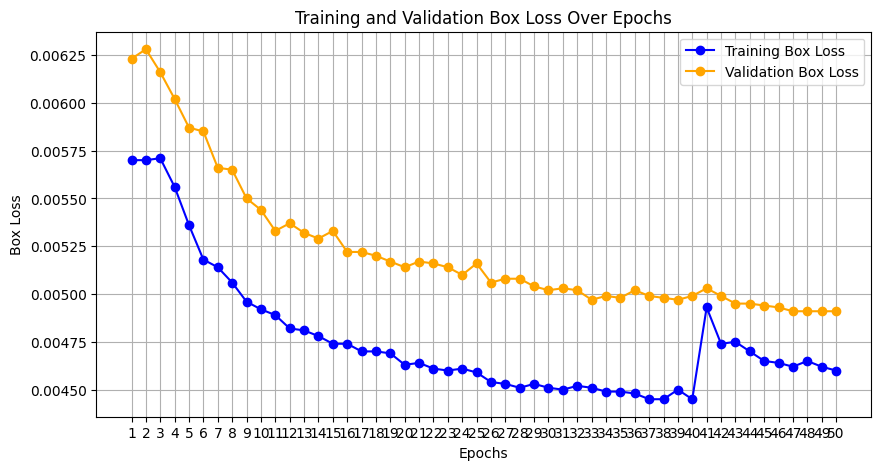

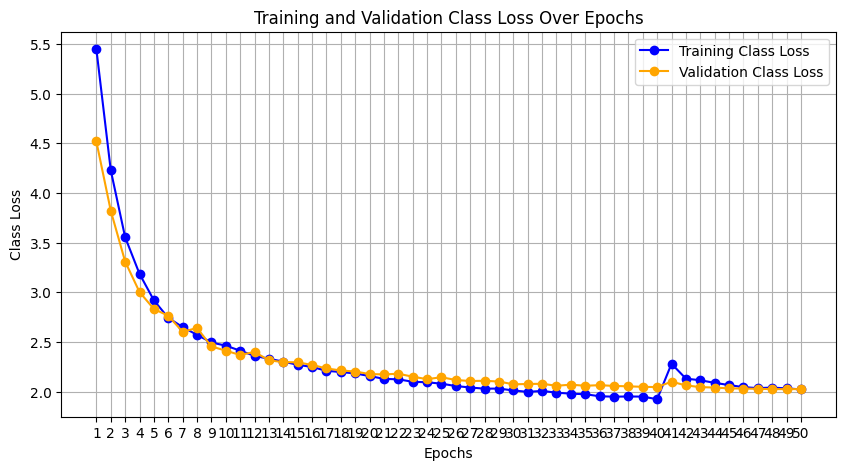

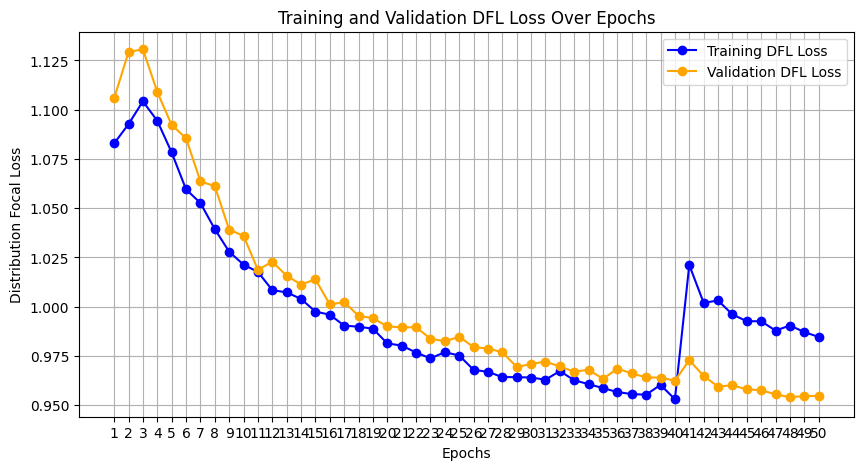

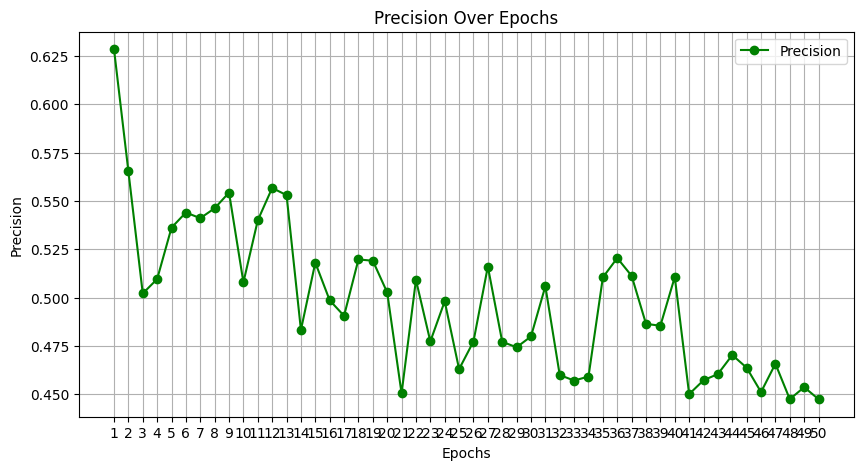

In [24]:
# Load the results CSV
results_path = "./runs/detect/train/results.csv"
results_df = pd.read_csv(results_path)

# Extract epochs
epochs = results_df["epoch"]

# Plot for box loss
plt.figure(figsize=(10, 5))
plt.plot(
    epochs,
    results_df["train/box_loss"],
    label="Training Box Loss",
    color="blue",
    marker="o",
)
plt.plot(
    epochs,
    results_df["val/box_loss"],
    label="Validation Box Loss",
    color="orange",
    marker="o",
)
plt.xlabel("Epochs")
plt.ylabel("Box Loss")
plt.title("Training and Validation Box Loss Over Epochs")
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

# Plot for class loss
plt.figure(figsize=(10, 5))
plt.plot(
    epochs,
    results_df["train/cls_loss"],
    label="Training Class Loss",
    color="blue",
    marker="o",
)
plt.plot(
    epochs,
    results_df["val/cls_loss"],
    label="Validation Class Loss",
    color="orange",
    marker="o",
)
plt.xlabel("Epochs")
plt.ylabel("Class Loss")
plt.title("Training and Validation Class Loss Over Epochs")
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

# Plot for distribution focal loss
plt.figure(figsize=(10, 5))
plt.plot(
    epochs,
    results_df["train/dfl_loss"],
    label="Training DFL Loss",
    color="blue",
    marker="o",
)
plt.plot(
    epochs,
    results_df["val/dfl_loss"],
    label="Validation DFL Loss",
    color="orange",
    marker="o",
)
plt.xlabel("Epochs")
plt.ylabel("Distribution Focal Loss")
plt.title("Training and Validation DFL Loss Over Epochs")
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

# Plot for precision
plt.figure(figsize=(10, 5))
plt.plot(
    epochs,
    results_df["metrics/precision(B)"],
    label="Precision",
    color="green",
    marker="o",
)
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision Over Epochs")
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

Final Training Metrics:
mAP@0.5: 0.2404
mAP@0.5:0.95: 0.1880


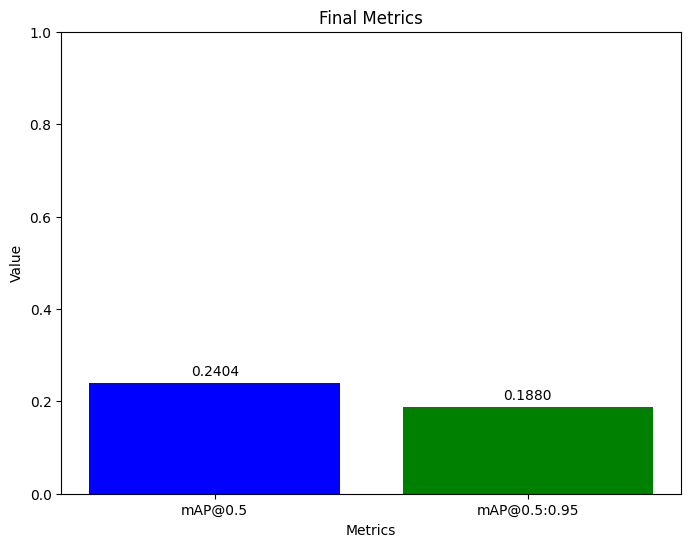

In [26]:
# Extract final evaluation metrics from the training results
final_map50_95 = training_results.box.map  # mAP@0.5:0.95
final_map50 = training_results.box.map50  # mAP@0.5
f1 = training_results.box.f1  # F1 score

# Print the final metrics
print("Final Training Metrics:")
print(f"mAP@0.5: {final_map50:.4f}")
print(f"mAP@0.5:0.95: {final_map50_95:.4f}")
# print(f"F1: {f1:.4f}")

# Prepare data for plotting
metrics = ["mAP@0.5", "mAP@0.5:0.95"]
values = [final_map50, final_map50_95]

# Plot the final mAP metrics
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=["blue", "green"])
plt.xlabel("Metrics")
plt.ylabel("Value")
plt.title("Final Metrics")
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha="center", va="bottom")
plt.show()

## Testing

In [27]:
print(test_dataset)

Dataset({
    features: ['image', 'label', 'classes_on_image', 'id'],
    num_rows: 200
})


In [1]:
# Prepare test dataset
def save_test(test_dataset, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for i in range(len(test_dataset)):
        img_np = np.array(test_dataset[i]["image"])

        # Prepare output paths
        img_path = os.path.join(output_dir, f"{i}.jpg")

        # Save image as JPEG
        Image.fromarray(img_np).save(img_path)


# Example directory structure
data_dir = "foodseg103_yolo"
save_test(test_dataset, os.path.join(base_path, data_dir, "test"))

NameError: name 'test_dataset' is not defined